```bash
nvidia-docker run --rm -it -p 6006:6006/tcp -p 8888:8888/tcp --ipc=host lidarclip:latest
```

In [1]:
import open3d as o3d
import numpy as np
import os, sys, time, yaml
# os.environ['DISPLAY'] = 'localhost:10.0'
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from scipy import stats

from collections import deque
from numpy.linalg import inv
import pickle
from functools import partial

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from utils.one import *
from utils.two import *

In [3]:
dataset = '/home/alex_odnakov/personal/dataset'
sequences_dir = os.path.join(dataset, "sequences")
sequence_folders = [
    f for f in sorted(os.listdir(sequences_dir))
    if os.path.isdir(os.path.join(sequences_dir, f))
]

seq_i=8
i=0
scan_list = {}
labels_list = {}
for i in sequence_folders:
    scan_list[i] = sorted(os.listdir(os.path.join(sequences_dir,i,'velodyne')))
    if os.path.isdir(os.path.join(sequences_dir,i,'labels')):
        labels_list[i] = sorted(os.listdir(os.path.join(sequences_dir,i,'labels')))
i = 400


a = SemLaserScan(color_dict, project=True)

a.open_scan(os.path.join(sequences_dir,sequence_folders[seq_i],'velodyne',scan_list[sequence_folders[seq_i]][i]))
a.open_label(os.path.join(sequences_dir,sequence_folders[seq_i],'labels',labels_list[sequence_folders[seq_i]][i]))
a.colorize()
# a.show(voxel=True,voxel_size=0.1)

In [4]:
second_path = "/home/alex_odnakov/personal/dataset/sequences/"+sequence_folders[seq_i]
poses = np.vstack(parse_poses(os.path.join(second_path,"poses.txt"), parse_calibration(os.path.join(second_path,"calib.txt")))).reshape((-1,4,4))

In [5]:
def scale_to_255(a, min, max, dtype=np.uint8):
    return (((a - min) / float(max - min)) * 255).astype(dtype)

def transform_cloud_to_world_frame(xyz, pose):
    points = np.hstack((xyz-pose[:3,3], np.zeros((xyz.shape[0], 1), dtype=xyz.dtype)))
    transformed_points = points @ np.linalg.inv(pose.T)
    return transformed_points[:,:3]
    
def point_cloud_2_birdseye(points,pose,labels,colors,
                           res=0.4,
                           side_range=(-50., 50.), 
                           fwd_range = (-50., 50.),
                           **kwargs):
    points = transform_cloud_to_world_frame(points,pose)
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()
    # return indices
    # KEEPERS
    x_points = np.concatenate((x_points[indices],x_points[indices]+res))
    y_points = np.concatenate((y_points[indices],y_points[indices]+res))
    z_points = np.concatenate((z_points[indices],z_points[indices]))
    labels = labels[indices]
    colors = colors[indices]
    # return indices
    

    x_img = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR

    x_img -= int(np.floor(side_range[0] / res))
    y_img += int(np.ceil(fwd_range[1] / res))
    print(z_points.min(),z_points.max())
    pixel_values = scale_to_255(z_points,
                           min=z_points.min(),
                           max=z_points.max(),)
    # pixel_values = z_points
    
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)

    im[y_img, x_img] = 255-pixel_values
    
    
    
    
    a = SemLaserScan(color_dict,**kwargs)
    pts = np.vstack((x_points,y_points,z_points)).T
    a.points = pts
    a.sem_label = np.concatenate((labels,labels))
    a.inst_label = np.concatenate((labels,labels))
    a.colorize()
    a.remissions = np.zeros((pts.shape[0]))
    a.do_range_projection()
    a.do_label_projection()
    sph_proj = a.proj_range
    nothing = np.where(sph_proj<0)
    sph_proj = scale_to_255(-sph_proj,
                           min=sph_proj.min(),
                           max=sph_proj.max(),)
    sph_proj[nothing] = 0
    sph_proj_labels = a.proj_sem_color

    return im,sph_proj,sph_proj_labels

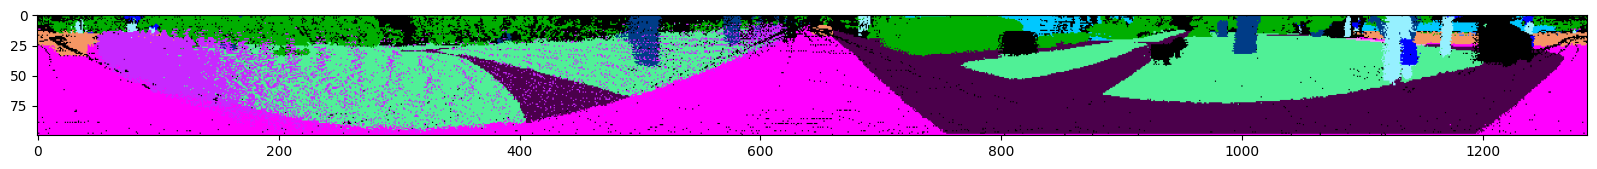

In [6]:
a = SemLaserScan(color_dict,H=100,W=1287)

a.open_scan("/home/alex_odnakov/personal/dataset/sequences/"+sequence_folders[seq_i]+"/whole_map_0_1000.bin")
a.open_label("/home/alex_odnakov/personal/dataset/sequences/"+sequence_folders[seq_i]+"/whole_map_0_1000.label")
a.colorize()
a.points  = transform_cloud_to_world_frame(a.points,poses[100])
plt.figure(figsize=(20,15))
# a.points = transform_cloud_to_world_frame(a.points,poses[100])
a.do_range_projection()
a.do_label_projection()
# plt.imshow(a.proj_range+1,cmap='gray', vmin=1, vmax=(a.proj_range+1).max())
# plt.imshow(a.proj_mask,cmap='gray')
plt.imshow(a.proj_sem_color)
# a.points += offset

In [ ]:


im,sph,_ = point_cloud_2_birdseye(a.points, poses[0],a.sem_label,a.sem_label_color,res=0.5, H=128,W=2048)#,fov_up=10,fov_down=-20)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(im,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sph,cmap='gray')

In [37]:
import cv2
image = cv2.imread('/home/alex_odnakov/personal/output.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [34]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# sam = sam_model_registry["vit_b"](checkpoint="gits/segment-anything/notebooks/sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    stability_score_thresh=0.9,
    min_mask_region_area=20)

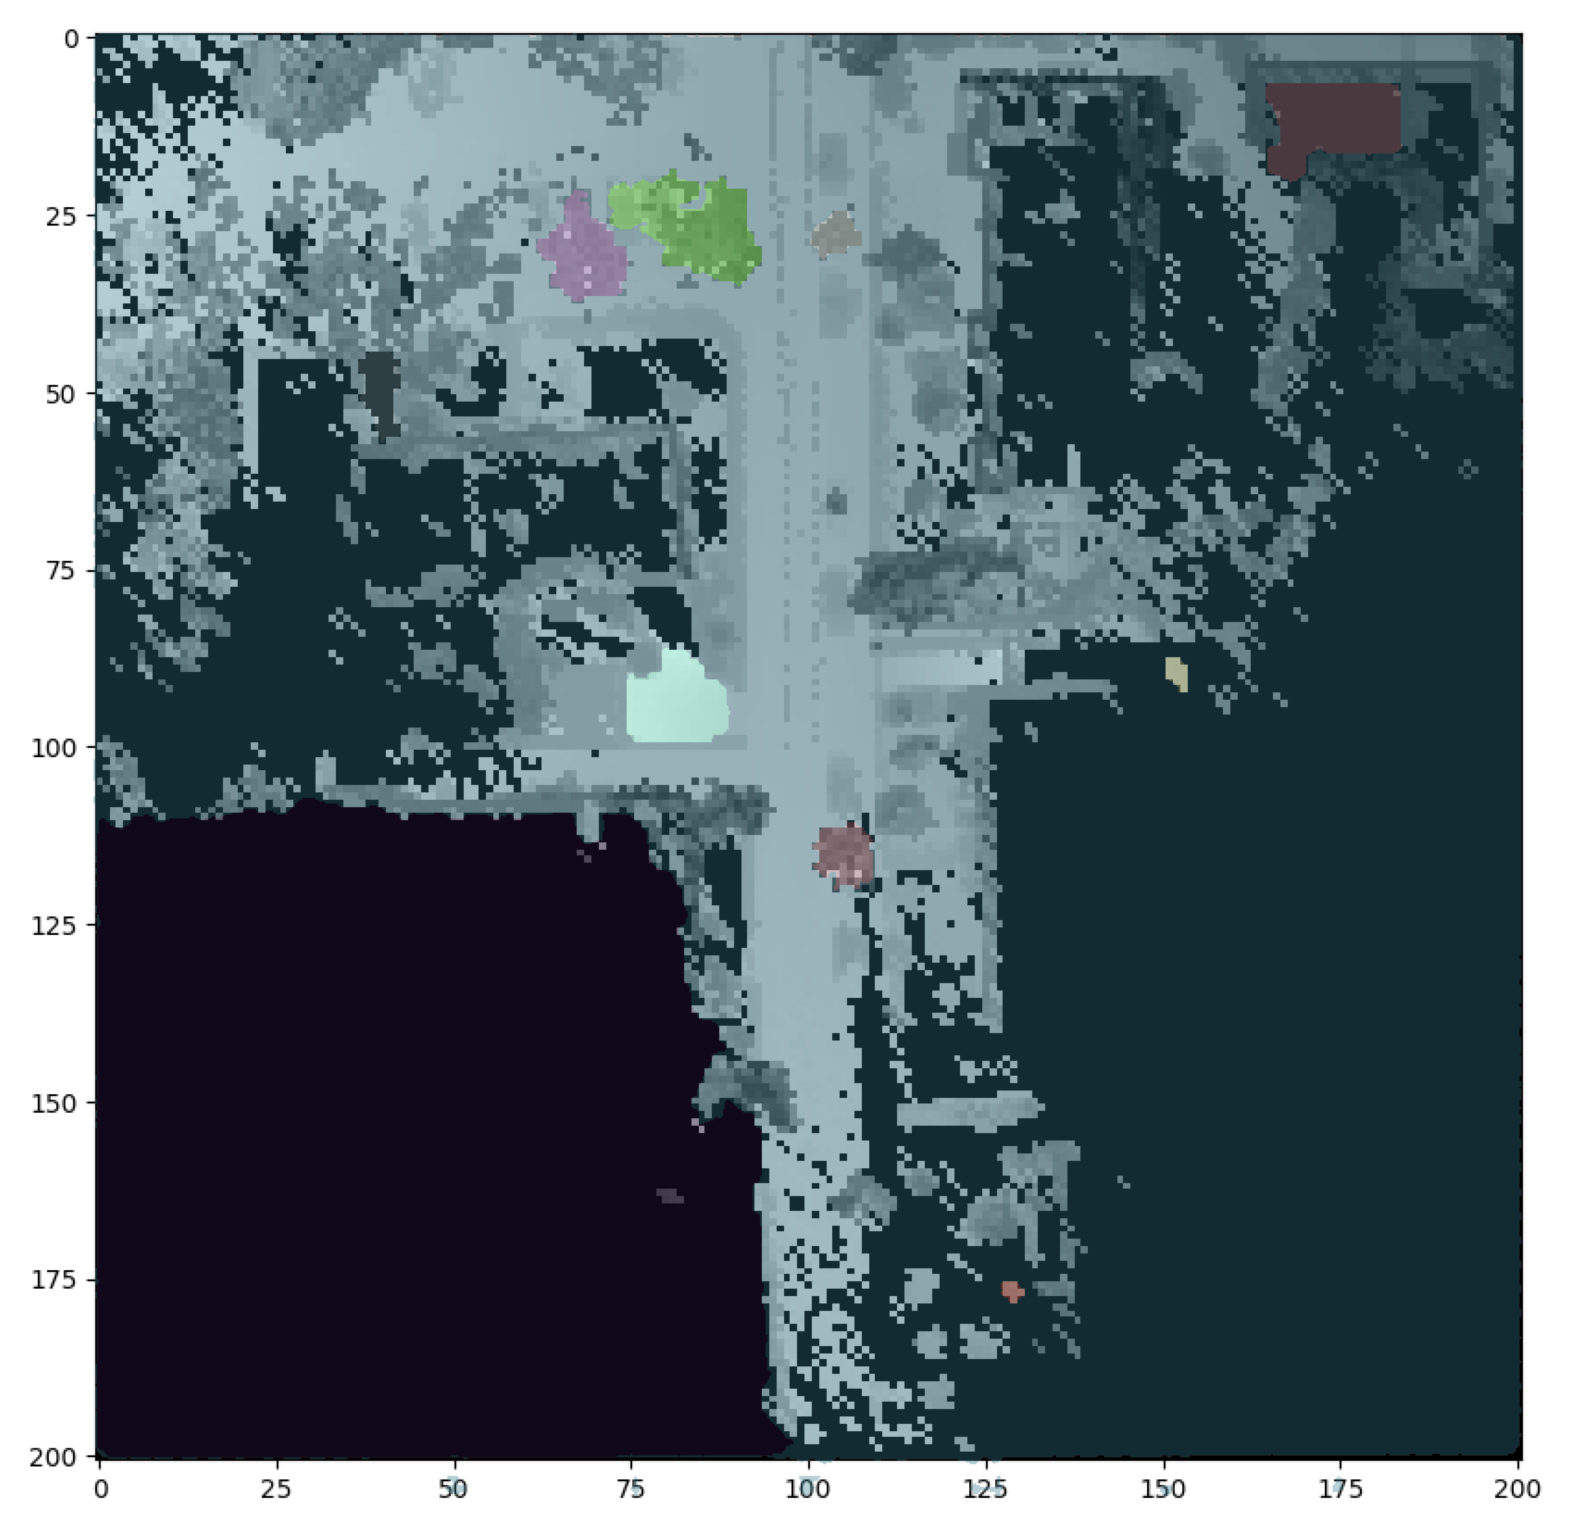

In [38]:
masks = mask_generator.generate(image)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 